In [121]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from modules.neqr import neqr
from modules.ladder import ladder_up
from modules.enhanced_grover import filter_oracle
from modules.qsubtract import subtract
from modules.qadd import qft_adder
from PIL import Image
import numpy as np

In [122]:
num_bits = 4
intensity_bits =  2
dimension = 2 ** num_bits

threshold_x = "00"
threshold_y = "00"
image = np.array([
    [0,0,0,0],
    [0,1,1,0],
    [0,1,1,0],
    [0,0,0,0]

])


In [123]:
def invert_image(image, bits=4):
    max_val = 2**bits - 1
    return max_val - image

def pad_image(image, target_shape=None):
    h, w = image.shape
    # Default: pad to 2× height and 2× width
    if target_shape is None:
        target_shape = (2 * h, 2 * w)
    new_h, new_w = target_shape
    pad_top = (new_h - h) // 2
    pad_bottom = new_h - h - pad_top
    pad_left = (new_w - w) // 2
    pad_right = new_w - w - pad_left
    padded = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=2**intensity_bits-1)
    return padded
def load_image(filepath, size=(16, 16)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array
def normalize_image(image, bits=3):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)
image = load_image('images/centered_8x8_square.jpg',size=(dimension,dimension))
image = normalize_image(image, intensity_bits)
#image = pad_image(image)
image = invert_image(image, intensity_bits) 
print(image)
np.savetxt("normalized_image.txt", image, fmt='%d')


[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 0 0 0 0 0 0 0 0 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [124]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
grad2 = QuantumRegister(intensity_bits, name='GradY')

sign1 = QuantumRegister(1, name='signX')
sign2 = QuantumRegister(1, name='signY')
oracle_x = QuantumRegister(1, name='oracle_x')
oracle_y = QuantumRegister(1, name='oracle_y')
a1 = QuantumRegister(1, name='a1')
a2 = QuantumRegister(1, name='a2')
output = QuantumRegister(1, name='output')
crX = ClassicalRegister(2*num_bits + 1, name='c') 
crY = ClassicalRegister(2*num_bits + 1, name='cy') 

qcX = QuantumCircuit(x, y, i1, grad1,sign1, a1, oracle_x, crX)
qcY = QuantumCircuit(x, y, i2, grad2, sign2, a2, oracle_y, crY)

In [125]:
# Superposition across all position values

qcX.h(x)
qcX.h(y)
qcX.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=15, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "signX"), index=0>, <Qubit register=(1, "a1"), index=0>, <Qubit register=(1, "oracle_x"), index=0>), clbits=())

In [126]:
# x gradient

neqr_gate1 = neqr(i1,x,y,image)
qcX.append(neqr_gate1, list(i1) + list(x) + list(y))

# Shift up: ladder_up
ladder = ladder_up(x)
qcX.append(ladder, list(x))

qcX.append(neqr_gate1, list(grad1) + list(x) + list(y))

qcX.draw('mpl')



sub1 = subtract(i1, grad1, sign1)
qcX.append(sub1, list(i1) + list(grad1) + list(sign1))



ladder_down = ladder.inverse()
qcX.append(ladder_down,list(x))

qcX.barrier()
qcX.x(sign1)
qcX.cx(sign1,a1)
qcX.ch(a1,sign1) 

ladder_control = ladder_up(x).control(1,label="cladder")

qcX.append(ladder_control, list(sign1) + list(x))


qcX.barrier()

qcX.x(a1)
qcX.h(oracle_x)

og = filter_oracle(threshold_x)
cog = og.control(2,label="Og")
qcX.append(cog, list(oracle_x) + list(sign1) + list(grad1))

qcX.append(cog, list(oracle_x) + list(a1) + list(grad1))

qcX.h(oracle_x)

qcX.barrier()

qcX.measure(list(x) + list(y) + list(oracle_x), list(crX))

2
[0, 0]
1 0
0 0


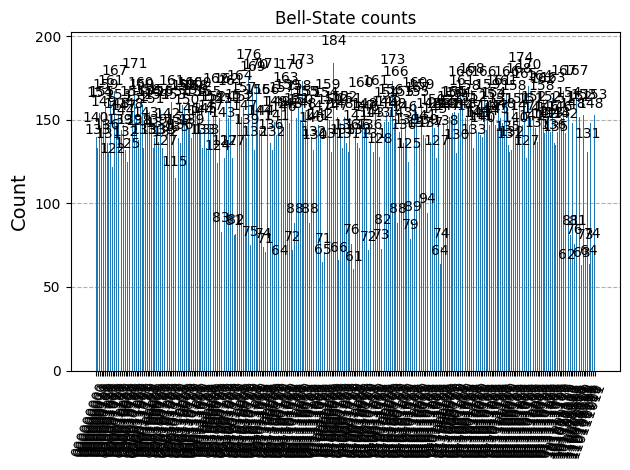

In [127]:
simulator = AerSimulator()
circ = transpile(qcX, simulator)

result = simulator.run(circ, shots=38000).result()
countsX = result.get_counts()
plot_histogram(countsX, title='Bell-State counts')

In [128]:
# Superposition across all position values

qcY.h(x)
qcY.h(y)
qcY.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=15, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "x"), index=0>, <Qubit register=(4, "x"), index=1>, <Qubit register=(4, "x"), index=2>, <Qubit register=(4, "x"), index=3>, <Qubit register=(4, "y"), index=0>, <Qubit register=(4, "y"), index=1>, <Qubit register=(4, "y"), index=2>, <Qubit register=(4, "y"), index=3>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradY"), index=0>, <Qubit register=(2, "GradY"), index=1>, <Qubit register=(1, "signY"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "oracle_y"), index=0>), clbits=())

In [129]:
# Y gradient

neqr_gate1 = neqr(i1,x,y,image)
qcY.append(neqr_gate1, list(i2) + list(x) + list(y))

# Shift up: ladder_up
ladder = ladder_up(y)
qcY.append(ladder, list(y))

qcY.append(neqr_gate1, list(grad2) + list(x) + list(y))

qcY.draw('mpl')



sub1 = subtract(i2, grad2, sign2)
qcY.append(sub1, list(i2) + list(grad2) + list(sign2))



ladder_down = ladder.inverse()
qcY.append(ladder_down,list(y))

qcY.barrier()
qcY.x(sign2)

qcY.cx(sign2,a2)
qcY.ch(a2,sign2) 

ladder_control = ladder_up(y).control(1,label="cladder")

qcY.append(ladder_control, list(sign2) + list(y))


qcY.barrier()

qcY.x(a2)
qcY.h(oracle_y)

og = filter_oracle(threshold_y)
cog = og.control(2,label="Og")
qcY.append(cog, list(oracle_y) + list(sign2) + list(grad2))

qcY.append(cog, list(oracle_y) + list(a2) + list(grad2))

qcY.h(oracle_y)

qcY.barrier()

qcY.measure(list(x) + list(y) + list(oracle_y), list(crY))

2
[0, 0]
1 0
0 0


In [130]:
#qcY.draw('mpl')

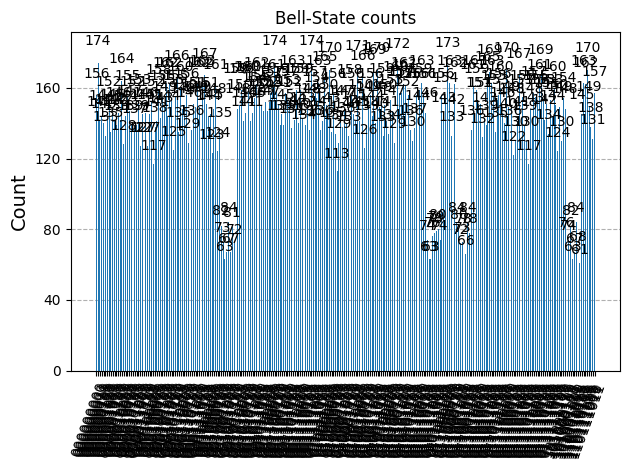

In [131]:
simulator = AerSimulator()
circ = transpile(qcY, simulator)

result = simulator.run(circ, shots=38000).result()
countsY = result.get_counts()
plot_histogram(countsY, title='Bell-State counts')

In [132]:
dim = 2 ** num_bits
edge_img = np.zeros((dim, dim), dtype=int)

def extract_edges(counts):
    edge_map = np.zeros((dim, dim), dtype=int)
    for qstate, count in counts.items():
        intensity_bin = qstate[:1]
        y_bin = qstate[1:1 + num_bits]
        x_bin = qstate[1 + num_bits:1 + 2 * num_bits]

        intensity = int(intensity_bin, 2)
        if intensity == 1:
            y = int(y_bin, 2)
            x = int(x_bin, 2)
            edge_map[y, x] = 1
    return edge_map

x_edge_map = extract_edges(countsX)
y_edge_map = extract_edges(countsY)

# Combine with logical OR
edge_img = np.logical_or(x_edge_map, y_edge_map).astype(int)

print(edge_img)


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


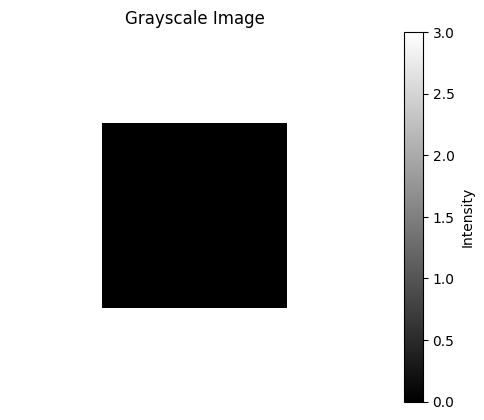

In [135]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


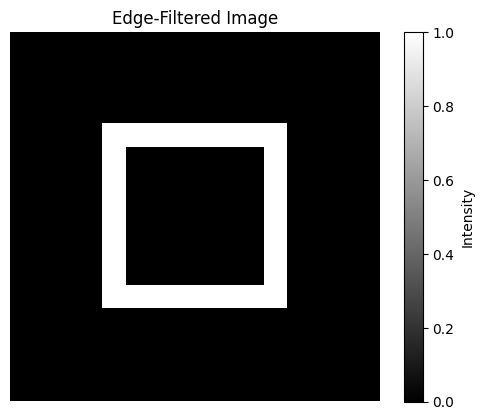

In [136]:
plt.imshow(edge_img, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Edge-Filtered Image')
plt.axis('off')
plt.show()